In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [8]:
prob = "LunarLander"
window_size = 10


In [11]:
# Load all your data files
data_files = {
    'QRNN_ASGNN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_ASGNN_mid_May6.npz',
    # 'QRNN_basic': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_basic_mid_May6.npz',
    'QRNN_random': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_random_mid_May6.npz',
    'QRNN_RS': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_RS_mid_QRNN_May6.npz',
    'QRNN_ASGNN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_ASGNN_mid_May6_CEM.npz',
    'QRNN_basic_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_basic_mid_May6_CEM.npz',
    'QRNN_random_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_QRNN_random_mid_May6_CEM.npz',
    # 'QRNN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\{prob}_MPC_QRNN_CEM_mid_April2_1000_StepsPerEpisodeContLLepisodes_results.npz',
    # 'QRNN_LBFGSB':
    
    '50NN_ASGNN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_ASGNN_mid_May6.npz',
    '50NN_basic': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_basic_mid_May6.npz',
    '50NN_random': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_random_mid_May6.npz',
    '50NN_RS': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_RS_mid_50NN_May6.npz',
    '50NN_ASGNN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_ASGNN_mid_May6_CEM.npz',
    '50NN_basic_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_basic_mid_May6_CEM.npz',
    '50NN_random_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_random_mid_May6_CEM.npz',
    # '50NN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\{prob}_MPC_50NN_CEM_mid_April2_1000_StepsPerEpisodeContLLepisodes_results.npz',
    # # '50NN_LBFGSB':

    'MSENN_ASGNN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_ASGNN_mid_May6.npz',
    'MSENN_ASGNN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_ASGNN_mid_May6.npz',
    'MSENN_basic': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_50NN_basic_mid_May6.npz',
    'MSENN_random': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_random_mid_May6.npz',
    'MSENN_RS': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_RS_mid_MSENN_May6.npz',
    'MSENN_ASGNN_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_ASGNN_mid_May6_CEM.npz',
    'MSENN_basic_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_basic_mid_May6_CEM.npz',
    'MSENN_random_CEM': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\{prob}_MPC_MSENN_random_mid_May6_CEM.npz',
    # # 'MSENN_LBFGSB':

    'DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DQN_results.npz',
    'IV-DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_IV_DQN_results.npz',
    'QR-DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_QR_DQN_results.npz',

    'A2C': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_A2C_results.npz',
    # 'DDPG': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DDPG_results.npz',
    'PPO': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_PPO_results.npz',
    # 'SAC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_SAC_results.npz',
    # 'TD3': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TD3_results.npz',
    # 'TQC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TQC_results.npz',
}

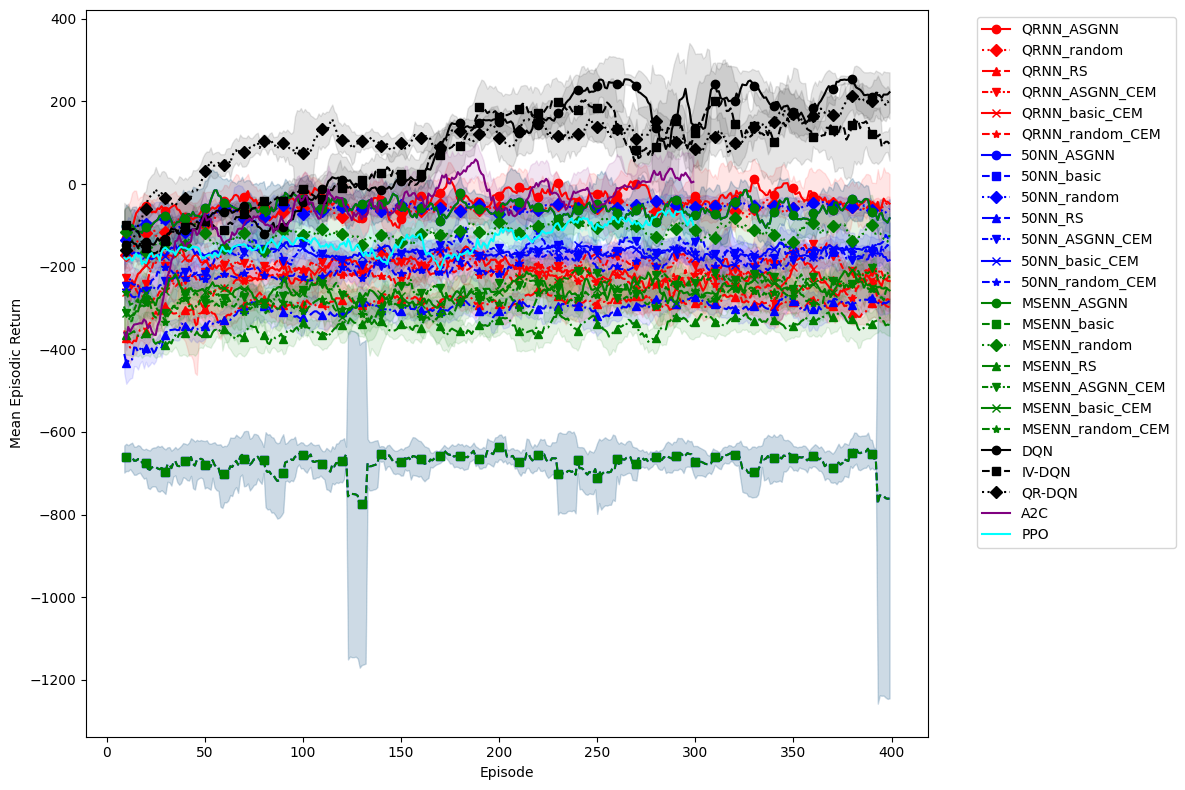

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define method families and their sub-methods
method_families = {
    '50NN': ['ASGNN', 'basic', 'random', 'RS', 'ASGNN_CEM', 'basic_CEM', 'random_CEM'],
    'MSENN': ['ASGNN', 'basic', 'random', 'RS', 'ASGNN_CEM', 'basic_CEM', 'random_CEM'],
    'QRNN': ['ASGNN', 'basic', 'random', 'RS', 'ASGNN_CEM', 'basic_CEM', 'random_CEM'],
    'RL': ['A2C', 'DDPG', 'PPO', 'SAC', 'TD3', 'TQC'],  # RL methods,
    'DQN': ['DQN', 'IV-DQN', 'QR-DQN'],
}

# Assign colors to each method family
colors = {
    '50NN': 'blue',
    'MSENN': 'green',
    'QRNN': 'red',
    'A2C': 'purple',
    'DDPG': 'darkorange',
    'PPO': 'cyan',
    'SAC': 'magenta',
    'TD3': 'brown',
    'TQC': 'olive',
    'DQN': 'black',
}

# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns

# Create a figure
plt.figure(figsize=(12, 8))

# Plot each dataset with consistent styling
for label, filepath in data_files.items():
    data = np.load(filepath)
    # mean_rewards = data['mean_rewards'][:100]
    # std_rewards = data['std_rewards'][:100]
    mean_rewards = data['mean_rewards']
    std_rewards = data['std_rewards']
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Determine method family and sub-method
    family = None
    submethod = None
    
    # Check if the label belongs to a method family
    for key in method_families:
        if key in label:
            family = key
            submethod = label.replace(key + '_', '')
            break
    
    # If no family is found (e.g., RL methods), treat 'RL' as family
    if family is None:
        if label in method_families['RL']:
            family = 'RL'
            submethod = label
    
    # Get marker and linestyle (only for non-RL methods)
    if family != 'RL':
        # Assign color and style
        color = colors.get(family, 'gray')  # Default to gray if not found
        try:
            marker = markers[method_families[family].index(submethod) % len(markers)]
            linestyle = linestyles[method_families[family].index(submethod) % len(linestyles)]
        except ValueError:
            marker = 'o'
            linestyle = '-'
    else:
        color = colors.get(submethod, 'gray')  # Default to gray if not found
        # RL methods: Assign unique markers/linestyles
        # marker = markers[method_families['RL'].index(submethod) % len(markers)]
        # linestyle = linestyles[method_families['RL'].index(submethod) % len(linestyles)]
    
    # Plot

    if family != 'RL':
        if family == "DQN":
            plt.plot(smoothed_mean, 
                 label=f"{submethod}", 
                 color=color,
                 marker=marker,
                 linestyle=linestyle,
                 markevery=10)
        else:
            plt.plot(smoothed_mean, 
                 label=f"{family}_{submethod}", 
                 color=color,
                 marker=marker,
                 linestyle=linestyle,
                 markevery=10)
    else:
        plt.plot(smoothed_mean, 
                label=label, 
                color=color,
                markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)

# Customize the plot
plt.xlabel('Episode')
plt.ylabel('Mean Episodic Return')
# plt.title('Comparison of Methods (Color = Family, Marker/Line = Sub-Method)')

# Legend: Group by method family (optional)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()